In [6]:
from fenics import *
from dolfin_adjoint import *
import pygmsh_mesh_functions
from pygmsh_mesh_functions import *
import meshio
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def hole_NPR(domain, c, l, theta, margin = 0.05):
    co, so = np.cos(theta), np.sin(theta)
    Rotation = np.array(((co, -so), (so, co)))
    shift_l = np.matmul(Rotation,np.array([-1,0]))
    shift_r = np.matmul(Rotation,np.array([ 1,0]))
    ell_c = add_ellipse(c, (1-margin)*np.sqrt(1/2)*l, (1-margin)*np.sqrt(1/2)*l)
    ell_l = add_ellipse(c+shift_l*l, (1+margin)*np.sqrt(1/2)*l, (1+margin)*np.sqrt(1/2)*l)
    ell_r = add_ellipse(c+shift_r*l, (1+margin)*np.sqrt(1/2)*l, (1+margin)*np.sqrt(1/2)*l)
    tool = subtract(ell_c, ell_l)
    tool = subtract(tool, ell_r)
    domain = subtract(domain, tool)
    
def hole_NPR_rounded(domain, c, l, theta, margin = 0.05):
    co, so = np.cos(theta), np.sin(theta)
    Rotation = np.array(((co, -so), (so, co)))
    scale = 1+np.sqrt(2)
    shift_l = np.matmul(Rotation,np.array([-1,0]))/scale
    shift_r = np.matmul(Rotation,np.array([ 1,0]))/scale
    shift_u = np.matmul(Rotation,np.array([0, 1]))/scale
    shift_d = np.matmul(Rotation,np.array([0,-1]))/scale
    ell_c = add_ellipse(c, (1)*np.sqrt(1/2)*l/scale, (1)*np.sqrt(1/2)*l/scale)
    ell_u = add_ellipse(c+shift_u*l, (1-margin)*np.sqrt(1/2)*l/scale, (1-margin)*np.sqrt(1/2)*l/scale)
    ell_d = add_ellipse(c+shift_d*l, (1-margin)*np.sqrt(1/2)*l/scale, (1-margin)*np.sqrt(1/2)*l/scale)
    ell_l = add_ellipse(c+shift_l*l, (1+margin)*np.sqrt(1/2)*l/scale, (1+margin)*np.sqrt(1/2)*l/scale)
    ell_r = add_ellipse(c+shift_r*l, (1+margin)*np.sqrt(1/2)*l/scale, (1+margin)*np.sqrt(1/2)*l/scale)
    tool = union(ell_c, ell_u)
    tool = union(ell_c, ell_d)
    tool = subtract(tool, [ell_l,ell_r])
    domain = subtract(domain, tool)

def hole_concave(domain, c, l, theta, margin = 0.05):
    co, so = np.cos(theta), np.sin(theta)
    Rotation = np.array(((co, -so), (so, co)))
    shift_l = np.matmul(Rotation,np.array([-1,0]))
    shift_r = np.matmul(Rotation,np.array([ 1,0]))
    ell_c = add_ellipse(c, (1)*np.sqrt(1/2)*l, (1)*np.sqrt(1/2)*l)
    ell_l = add_ellipse(c+shift_l*l, (1+margin)*np.sqrt(1/2)*l, (1+margin)*np.sqrt(1/2)*l)
    ell_r = add_ellipse(c+shift_r*l, (1+margin)*np.sqrt(1/2)*l, (1+margin)*np.sqrt(1/2)*l)
    tool = subtract(ell_c, ell_l)
    tool = subtract(tool, ell_r)
    domain = subtract(domain, tool)

def hole_convex(domain, c, l, theta, margin = 0.05):
    co, so = np.cos(theta), np.sin(theta)
    Rotation = np.array(((co, -so), (so, co)))
    shift_l = np.matmul(Rotation,np.array([-1,0]))
    shift_r = np.matmul(Rotation,np.array([ 1,0]))
    ell_c = add_ellipse(c, (1-margin)*np.sqrt(1/2)*l, (1-margin)*np.sqrt(1/2)*l)
    domain = subtract(domain, ell_c)

In [89]:
def arrange_array(n_holes_x, n_holes_y, 
                  size = np.min((n_holes_x,n_holes_y)), scale = 1, 
                  freq = 1, phase = 0, shift = np.array([0,0])):
    
    min_n_holes = np.min((n_holes_x,n_holes_y))
    l = scale/min_n_holes

    xx = scale*(np.arange(n_holes_x)-n_holes_x/2+0.5)/size+0.5
    yy = scale*(np.arange(n_holes_y)-n_holes_y/2+0.5)/size+0.5
    cx,cy = np.meshgrid(xx,yy)
    cx = cx.reshape(n_holes_x*n_holes_y)
    cy = cy.reshape(n_holes_x*n_holes_y)
    c = np.vstack((cx,cy)) # hole coordinate

    s_xx = (-1)**np.arange(n_holes_x)
    s_yy = (-1)**np.arange(n_holes_y)
    sgn_x,sgn_y = np.meshgrid(s_xx,s_yy)
    sgn = sgn_x*sgn_y
    sgn = sgn.reshape(n_holes_x*n_holes_y)
    theta = np.pi*(sgn/2)*freq + phase # hole orientation
    theta = theta + (np.random.rand(len(theta))-0.5)*0.5
    
    return(c, theta)

In [90]:
# arrange the tools
c, theta = arrange_array(5, 3, size = 4, scale = 1, freq = 0.5, phase = np.pi/4)

In [91]:
theta

array([ 1.62703449, -0.11759215,  1.37611814, -0.17851527,  1.7991029 ,
        0.17209821,  1.81686588, -0.00929387,  1.59810872, -0.03450774,
        1.73229757, -0.19925714,  1.43968765,  0.24608129,  1.40462398])

In [92]:
# s_xx = (-1)**np.arange(n_holes_x)
# s_yy = (-1)**np.arange(n_holes_y)
# sgn_x,sgn_y = np.meshgrid(s_xx,s_yy)
# sgn = sgn_x*sgn_y
# sgn = sgn.reshape(n_holes_x*n_holes_y)
# theta = np.pi*(1-sgn)/4

# xx_l = scale*(-1-n_holes_x/2+0.5)/min_n_holes+0.5
# xx_r = scale*(len(xx)-n_holes_x/2+0.5)/min_n_holes+0.5
# cx_l,cy_l = np.meshgrid(xx_l,yy)
# cx_r,cy_r = np.meshgrid(xx_r,yy)
# c_l = np.vstack((cx_l.T,cy_l.T))
# c_r = np.vstack((cx_r.T,cy_r.T))

# s_xx_l = (-1)**(-1)
# s_xx_r = (-1)**(len(xx))
# sgn_l = s_xx_l*s_yy
# sgn_r = s_xx_r*s_yy

Info    : Running '/home/fenics/.local/bin/gmsh -3 /tmp/tmp3w_2ozou.geo -format msh -bin -o /tmp/tmpo2xvmc7p.msh' [Gmsh 4.9.5, 1 node, max. 1 thread]
Info    : Started on Mon May  2 01:29:43 2022
Info    : Reading '/tmp/tmp3w_2ozou.geo'...
Info    : Cannot bind existing OpenCASCADE surface 7 to second tag 8
Info    : Could not preserve tag of 2D object 8 (->7)
Info    : Cannot bind existing OpenCASCADE surface 7 to second tag 9
Info    : Could not preserve tag of 2D object 9 (->7)
Info    : Cannot bind existing OpenCASCADE surface 20 to second tag 21
Info    : Could not preserve tag of 2D object 21 (->20)
Info    : Cannot bind existing OpenCASCADE surface 20 to second tag 22
Info    : Could not preserve tag of 2D object 22 (->20)
Info    : Cannot bind existing OpenCASCADE surface 48 to second tag 49
Info    : Could not preserve tag of 2D object 49 (->48)
Info    : Cannot bind existing OpenCASCADE surface 48 to second tag 50
Info    : Could not preserve tag of 2D object 50 (->48)
Info  

Info    : Done meshing 2D (Wall 0.202077s, CPU 0.202049s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 2.08e-05s, CPU 2.1e-05s)
Info    : 5141 nodes 10482 elements
Info    : Writing '/tmp/tmpo2xvmc7p.msh'...
Info    : Done writing '/tmp/tmpo2xvmc7p.msh'
Info    : Stopped on Mon May  2 01:29:44 2022 (From start: Wall 1.27626s, CPU 1.44659s)


5141

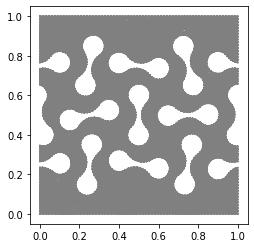

In [94]:
reset_geometry()

Lx = 1
Ly = 1

meshsize_min = 0.015
meshsize_max = 0.015

pygmsh_mesh_functions.hmeshmin = meshsize_min
pygmsh_mesh_functions.hmeshmax = meshsize_max

domain = add_polygon([(0, 0), (Lx, 0), (Lx, Ly), (0, Ly)])
X0 = np.array([0, 0])

#OPERATIONS ON DOMAIN
for i in range(len(theta)):
    hole_NPR_rounded(domain, c[:,i], l, theta[i], margin = 0.2)

for i in range(len(yy)):
    if sgn_l[i] == 1:
        hole_concave(domain, c_l[:,i], l, 0, margin = 0.2)
    else:
        hole_convex(domain, c_l[:,i], l, 0, margin = 0.2)
    if sgn_r[i] == 1:
        hole_concave(domain, c_r[:,i], l, 0, margin = 0.2)
    else:
        hole_convex(domain, c_r[:,i], l, 0, margin = 0.2)


#CREATE AND STORE MESH
sample_name = "test_NPR_rounded_rand.xdmf"
out_dir = pathlib.Path("output_files")
out_dir.mkdir(parents=True, exist_ok=True)
mesh = create_fenics_mesh(mesh_path = out_dir / sample_name, verbose=True)
cell_type = mesh.cell_name()
with create_XDMFFile(out_dir / sample_name) as xf:
    xf.write(mesh)
    
plot(mesh)
len(mesh.coordinates())